# 1. Load a subset of Quotations from politicians

In [1]:
import pandas as pd
from src.data_wrangling.load_data import load_political_quotes
quotes = []
for batch in load_political_quotes(country=['United Kingdom'], political_alignment=['right-wing'],
                                   year=[2020], chunksize=20000):
    quotes.append(batch)

In [2]:
politician_quotes = pd.concat(quotes, axis=0, ignore_index=False)
politician_quotes = politician_quotes[['quotation', 'speaker', 'qid']]
politician_quotes

,quotation,speaker,qid
quoteID,,,
2020-03-19-019777,He felt yesterday was the time to decide to cl...,Arlene Foster,Q4792148
2020-01-11-028644,Michelle's narrative of the past 40 years coul...,Arlene Foster,Q4792148
2020-03-19-011600,"Clearly a memo has gone round,",David Campbell Bannerman,Q546231
2020-01-07-069807,the terms in which we're leaving,Nigel Farage,Q318471
2020-01-08-012804,Coleraine got the university; the city did not...,Willie Hay,Q8011049
...,...,...,...
2020-02-10-036325,If he had any shred of integrity he would have...,Jim Allister,Q3499853
2020-01-29-055575,It's all over! Finished!,Nigel Farage,Q318471
2020-02-19-042149,In particular what we want to do... is try to ...,George Eustice,Q303510


# 2. Using Top2Vec for topic extraction
Our basic idea for extracting topics from the quotes was as followed:
1) using a pretrained embedding to embed the quotes into a semantic space. Our idea was to use word2vec for each word and average over each quote.
2) probably reduce the dimensonality of the embedding. If the embedding has too many dimensions, this could reduce the quality of the clustering result, as well as be too computationally expensive.
3) cluster the lower dimensional embedding and use clusters as topics

We found a already existing tool called [Top2Vec](https://github.com/ddangelov/Top2Vec) which does basically this and offers some convinience features.
Main differences are:
- the usage of a doc2vec model for the embedding. It is trained on the input data, we will probably replace it by another embedding.
- reassigning "noise" documents/quotes to closest cluster

We descided to use this instead of coding the pipeline ourself, since its already there and uses some indexed datastructure to speed it up and already allows to save the entire trained model. We will probably adapt this implementation to our needs.

## Example usage of top2vec on quotedata from 2020

### Imports

In [3]:
import pandas as pd

from top2vec import Top2Vec

### Configure Top2Vec
Here we configure Top2Vec and prepare the data. Top2Vec wants the documents and the ids as a list...

In [4]:
documents_for_top2vec = politician_quotes['quotation'].tolist()
ids_for_top2vec  = politician_quotes.index.tolist()

Here we configure the dimensionality reduction(UMAP) and the clustering(HDBSCAN) steps.

In [5]:
umap_args = {'n_neighbors': 5,
             'n_components': 5,
             'metric': 'cosine'}
hdbscan_args = {'min_cluster_size': 5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'#, 'core_dist_n_jobs': 1 if pickable error
               }

The speed option chooses a preconfiguration of for doc2vec. Here we used the quickest preset. But this we could also  modify later in the top2vec code manually to get optimal results.

### Execute the pipeline(Doc2Vec, UMAP, HDBSCAN, AssignToTopics)

In [6]:
model = Top2Vec(documents_for_top2vec, document_ids=ids_for_top2vec, speed='fast-learn',
                umap_args=umap_args, hdbscan_args=hdbscan_args, workers=8)

2021-11-12 22:00:44,774 - top2vec - INFO - Pre-processing documents for training
2021-11-12 22:00:44,956 - top2vec - INFO - Creating joint document/word embedding
2021-11-12 22:00:52,659 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-12 22:01:07,184 - top2vec - INFO - Finding dense areas of documents
2021-11-12 22:01:07,386 - top2vec - INFO - Finding topics


... and save the model for later.

In [7]:
model.save("2020-doc2vec-fast2")

## A quick look at the results:

How many topics did we find?

In [8]:
model.get_num_topics()

3

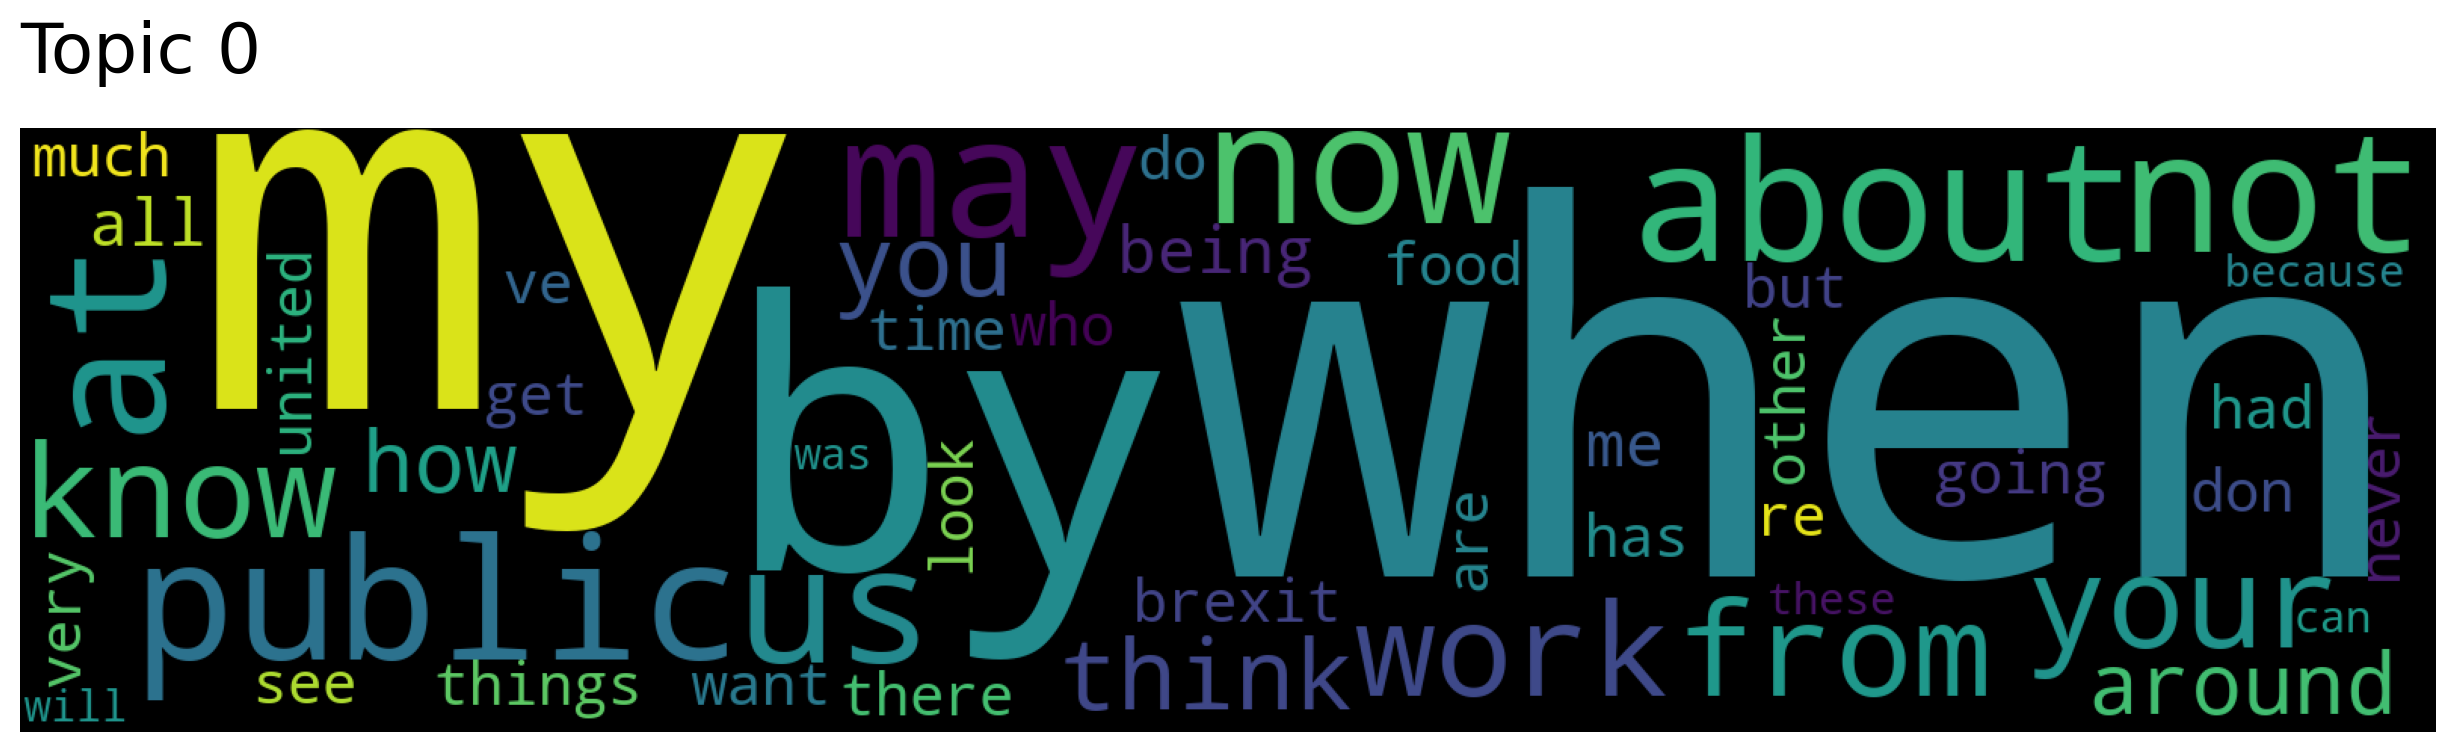

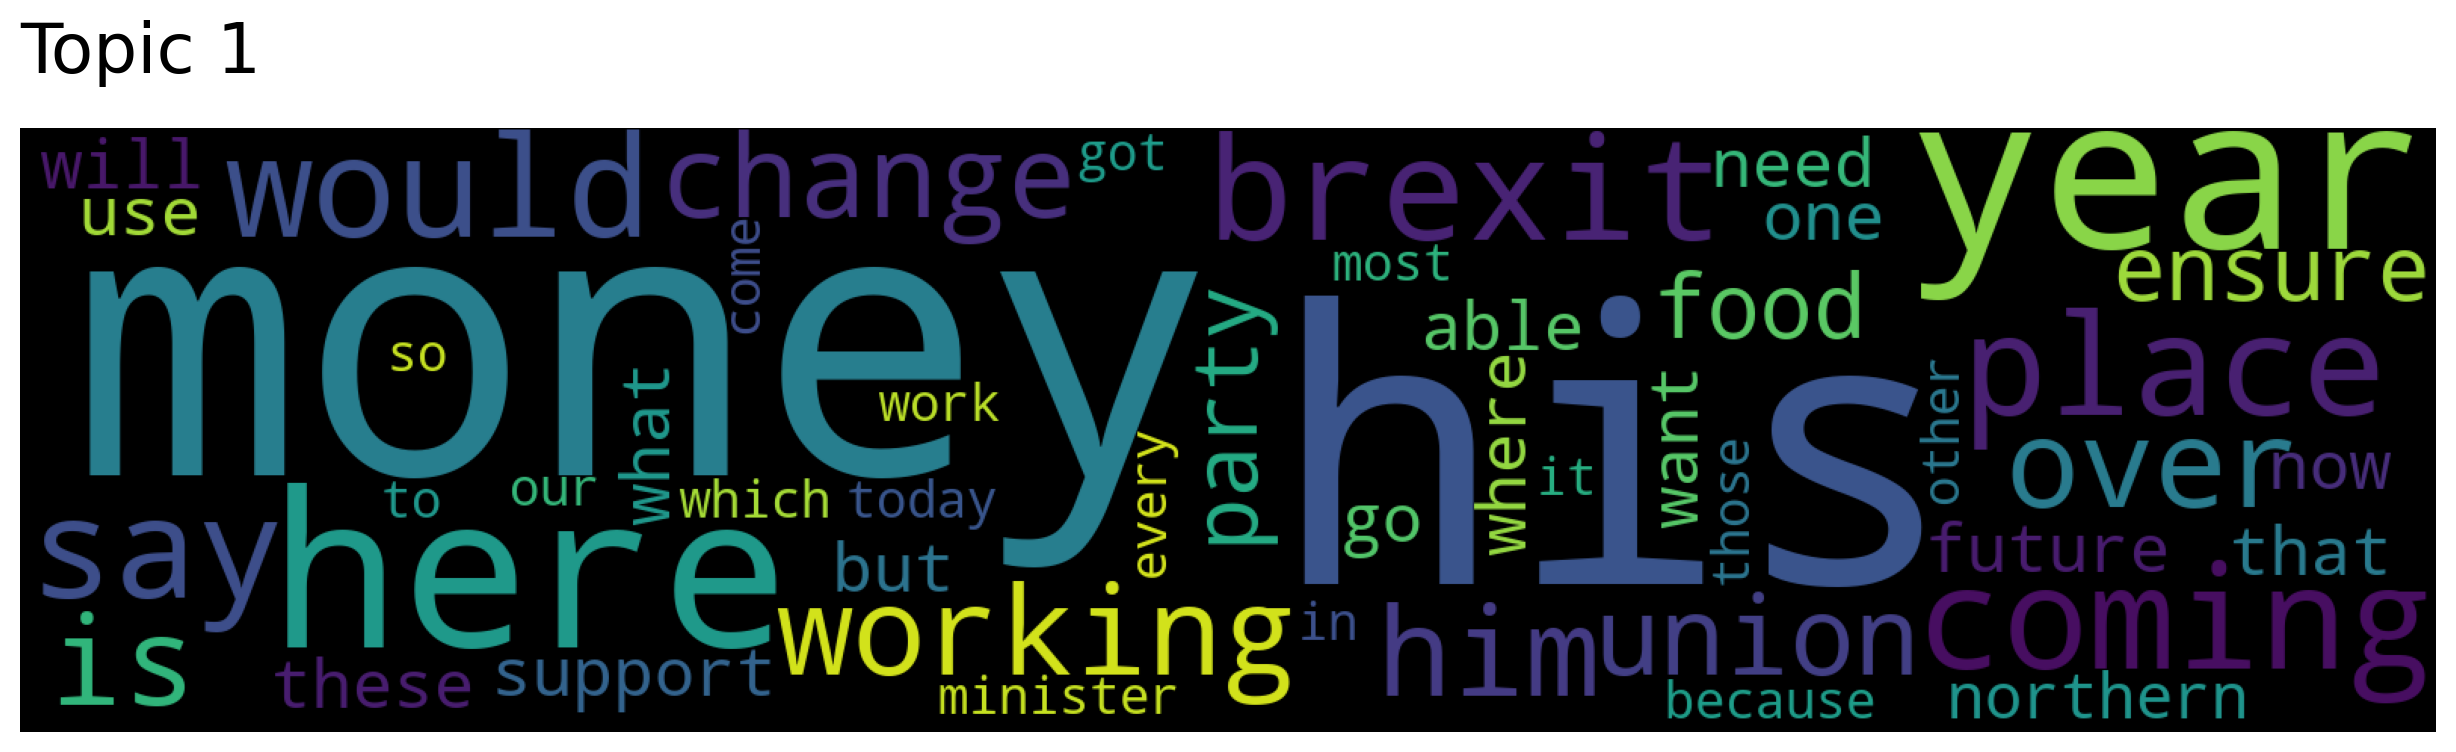

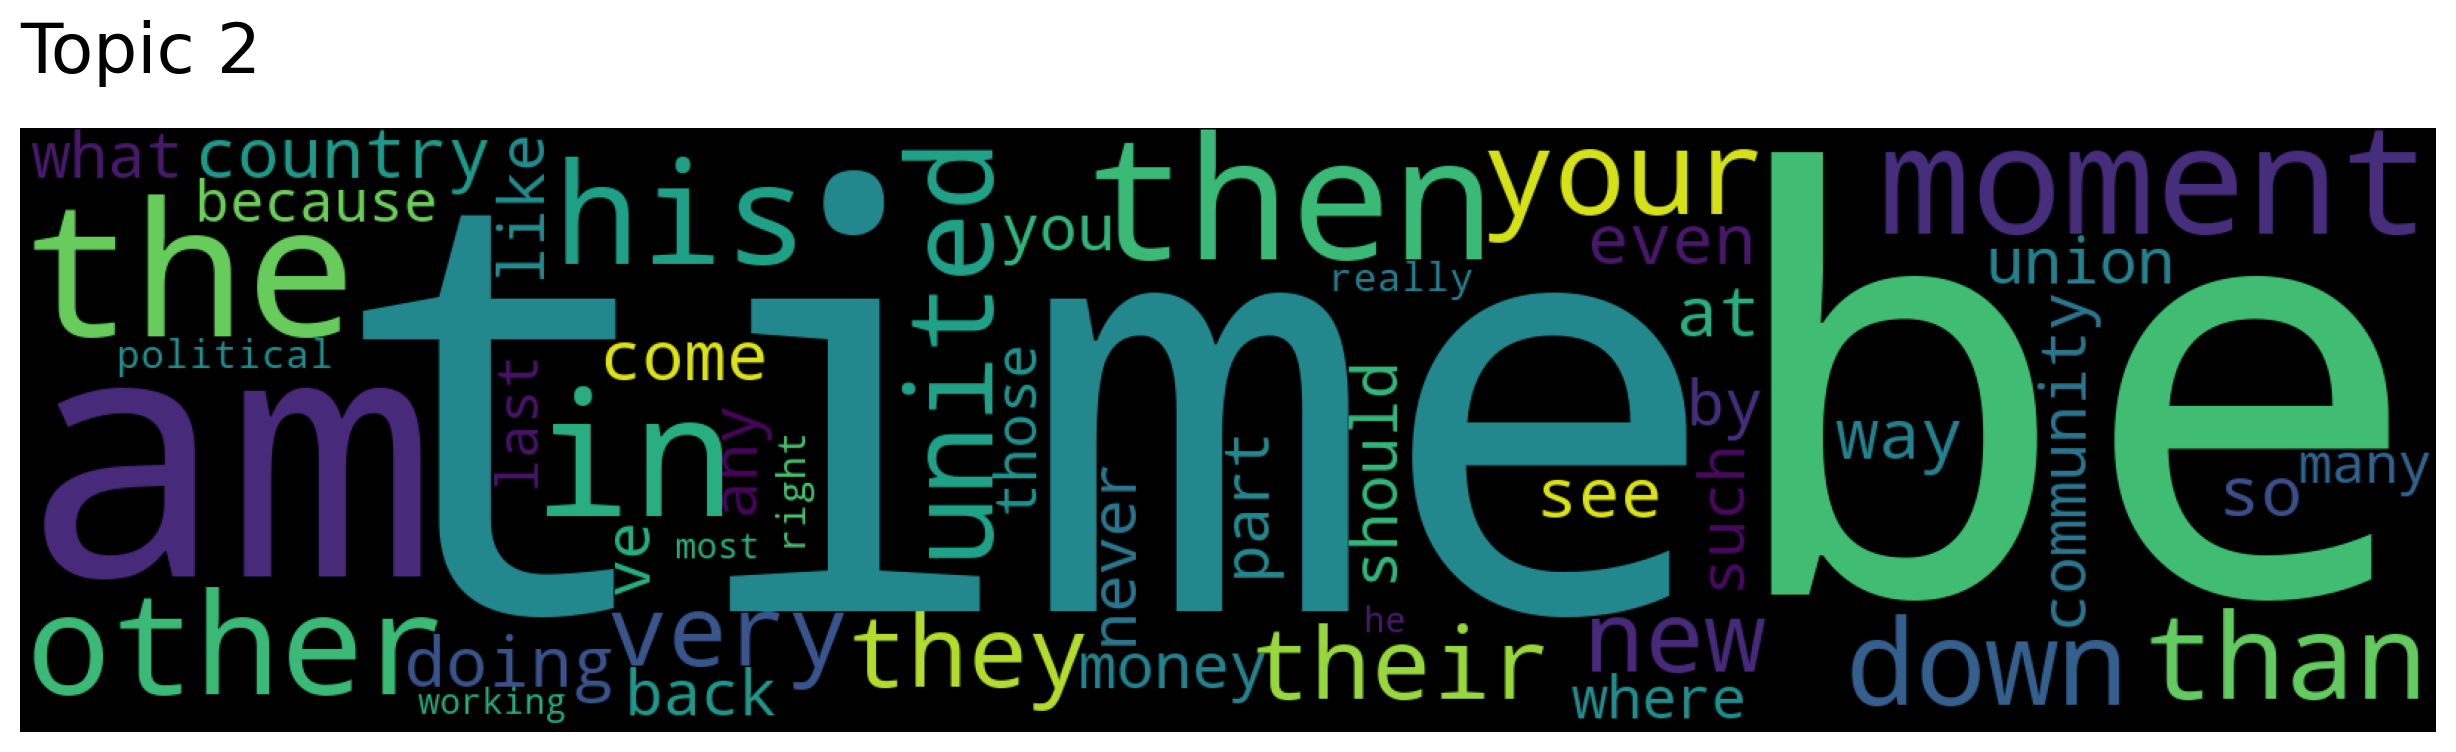

In [34]:
for i in range(model.get_num_topics()):
    model.generate_topic_wordcloud(i)

# 3. Sentiment analysis with TextBlob

We want to know if the quotes have a positive or a negative intention. In the following section a sentiment analysis approach was done with TextBlob. TextBlob is a python library for Natural Language Processing (NLP).It uses Natural Language ToolKit (NLTK) to achieve its tasks. It can be used for complex analysis on textual data.

In [35]:
import pandas as pd
from textblob import TextBlob

### Extract some quotes from a single cluster topic


In [36]:
quotations, quotation_scores, quotation_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)

In [37]:
# example data frame, must be replaced by dataframe of citations for one topic (filtering)
# list = ['This is a good example', 'This is a bad example', 'I dont like it', 'I love it', 'What is it?', 'These immigrants are good', 'These immigrants destroy everything']
# df = pd.DataFrame(list, columns=['quotation'])
df = politician_quotes.loc[document_ids, :]

In [38]:
from src.sentiment_analysis import get_subjectivity, get_polarity, get_sentiment
# add to DataFrame
df['polarity'] = df['quotation'].apply(get_polarity)
df['analysis'] = df['polarity'].apply(get_sentiment)
df.head() 

,quotation,speaker,qid,polarity,analysis
quoteID,,,,,
2020-03-22-013383,"I think that when you protest, it's maybe 25% ...",Sargon of Akkad,Q28924867,0.276190,Positive
2020-02-24-010667,"Defra [ the Department of Environment, Food an...",George Eustice,Q303510,0.195833,Positive
2020-01-29-041680,"I will miss the drama, I will miss the theatre...",Nigel Farage,Q318471,0.209524,Positive
2020-01-13-068671,The people of Northern Ireland do not want us ...,Jim Shannon,Q478702,-0.026136,Negative
2020-01-09-036886,"I want today to make the point to this House, ...",Carla Lockhart,Q24052782,0.242500,Positive


In [39]:
# count pos, neg and neutral citations
tb_counts = df.analysis.value_counts()
print(tb_counts)

Positive    4
Negative    1
Name: analysis, dtype: int64


### Visualize the results

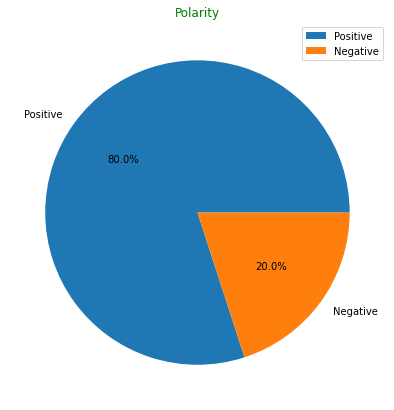

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.title("Polarity", color = 'g')
plt.pie(tb_counts.values, labels = tb_counts.index,  autopct='%1.1f%%')
plt.legend()
plt.show()

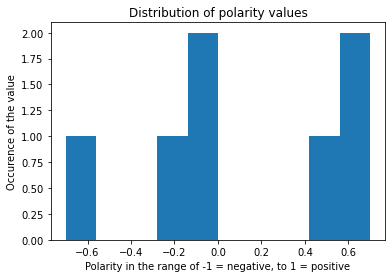

In [48]:
plt.title('Distribution of polarity values')
plt.hist(df['Polarity'])
plt.xlabel('Polarity in the range of -1 = negative, to 1 = positive')
plt.ylabel('Occurence of the value')
plt.show()

### Load the data

In [ ]:
import pandas as pd
import scripts.word2vec as w2v

In [ ]:
# Download file if not present
df = pd.read_csv('quotes-2020-politicians.csv.gz', compression='gzip')

In [ ]:
df.head()

In [ ]:
# Extend dataframe with the quotes vectors

w2v.extend_dataframe(df, 'quotation', 'quotation_vector')

In [ ]:
df.head()